# Initialisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

In [2]:
EMP=pd.read_csv("https://raw.githubusercontent.com/kilianguillon/Projet_statapp/main/data/EMP_deplacements_Charme.csv",
                sep=";", encoding='latin-1')

In [3]:
#Création d'une base ne prenant que les premiers trajets
EMP_prems = EMP[EMP["num_dep_V"]==1]

# Lieu du premier déplacement de la journée

In [4]:
pd.DataFrame(EMP_prems["Motif"].value_counts()).head() #Motif du déplacement (pas de pondération)

,count
Motif,
Travailler dans son lieu fixe et habituel,1838
Se rendre dans une grande surface ou un centre commercial (y compris boutiques et services),1111
"Se rendre dans un centre de proximité, petit commerce, supérette, boutiques, services (banque, cordonnier.) (hors centre commercial)",891
Visite à la famille,471
Accompagner quelqu'un à un autre endroit,408


In [5]:
#Arrivée du déplacement pas de pond
pd.DataFrame(EMP_prems["Lieu_Arrivee"].value_counts())

,count
Lieu_Arrivee,
Rue,2577
Parking,2486
Entreprise,1441
Domicile,570
Sans,275


Pour pouvoir correctement évaluer les habitudes de déplacement, on doit pondérer chaque voyage. Etant donné que c'est un besoin récurrent, je crée une fonction qui prend en entrée un DF et la variable dont l'on veut connaître les occurences de ses entrées. La fonction rend une table avec les occurences pondérées et la proportion.

In [6]:
def count_occ_pond(data, nom_var, nom_pond, taille=10):
    value = data[nom_var].unique() #cette fonction est utile pour des variables prenant un nbre de valeurs finies
    result_dict = {nom_var: [], 'Occurences pondérées': [], 'Proportion':[]} #à chaque valeur on associe la somme des occurences pondérées
    N=data[nom_pond].replace(',', '.', regex=True).astype(float).sum()
    for val in value :
        somme_pond = data[data[nom_var] == val][nom_pond].replace(',', '.', regex=True).astype(float).sum() #replace car la base utilisée est "française"
        result_dict[nom_var].append(val)
        result_dict['Occurences pondérées'].append(somme_pond)
        result_dict['Proportion'].append(round(100*somme_pond/N,2))
    return pd.DataFrame(result_dict).sort_values('Occurences pondérées', ascending=False).reset_index(drop=True).head(taille)

In [7]:
count_occ_pond(EMP_prems, "Motif", "POND_JOUR")

,Motif,Occurences pondérées,Proportion
0,Travailler dans son lieu fixe et habituel,4.820732e+07,27.04
1,Se rendre dans une grande surface ou un centre...,2.253802e+07,12.64
2,"Se rendre dans un centre de proximité, petit c...",1.891414e+07,10.61
3,Accompagner quelqu'un à un autre endroit,1.351374e+07,7.58
4,Visite à la famille,1.072364e+07,6.02
5,"Soins médicaux ou personnels (médecin, coiffeur.)",6.666349e+06,3.74
6,Visite à des amis,6.128020e+06,3.44
7,Faire du sport,5.893799e+06,3.31
8,Aller chercher quelqu'un à un autre endroit,5.076578e+06,2.85
9,Travailler en dehors d'un lieu fixe et habitue...,4.679032e+06,2.62


In [8]:
count_occ_pond(EMP_prems, "Lieu_Arrivee", "POND_JOUR")

,Lieu_Arrivee,Occurences pondérées,Proportion
0,Rue,6.142194e+07,34.45
1,Parking,5.700055e+07,31.97
2,Entreprise,3.775752e+07,21.18
3,Domicile,1.366802e+07,7.67
4,Sans,8.432261e+06,4.73


# Lieu en fonction de l'heure d'arrivée et du jour

## Week_end ou non ?

In [9]:
#création d'une variable weekend (si les diffs entre samedi et dimanche sont faibles)
EMP_prems.loc[:, "WE"] = 0
EMP_prems.loc[EMP_prems["TYPE_jour"].isin(["samedi", "dimanche"]), "WE"] = 1

/tmp/ipykernel_72789/3819941130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EMP_prems.loc[:, "WE"] = 0


On regroupe samedi et dimanche pour simplifier. Les habitudes de premier déplacement sont légèrement différentes (plus de visite à la famille ou retour au domicile le dimanche), mais ces deux jours différent encore plus avec les autres.

#count_occ_pond(EMP_prems[EMP_prems["TYPE_jour"]=="samedi"], "Motif", "POND_JOUR"), count_occ_pond(EMP_prems[EMP_prems["TYPE_jour"]=="dimanche"], "Motif", "POND_JOUR")

In [10]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "Motif", "POND_JOUR") #Motif de premier déplacement en semaine

,Motif,Occurences pondérées,Proportion
0,Travailler dans son lieu fixe et habituel,4.473707e+07,33.36
1,Se rendre dans une grande surface ou un centre...,1.471521e+07,10.97
2,Accompagner quelqu'un à un autre endroit,1.151086e+07,8.58
3,"Se rendre dans un centre de proximité, petit c...",1.102945e+07,8.23
4,"Soins médicaux ou personnels (médecin, coiffeur.)",6.023393e+06,4.49
5,Visite à la famille,5.599544e+06,4.18
6,Travailler en dehors d'un lieu fixe et habitue...,4.283752e+06,3.19
7,Aller chercher quelqu'un à un autre endroit,4.032286e+06,3.01
8,Visite à des amis,3.655889e+06,2.73
9,Faire du sport,3.294035e+06,2.46


In [11]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "Lieu_Arrivee", "POND_JOUR") #Lieu arrivée premier déplacement en semaine

,Lieu_Arrivee,Occurences pondérées,Proportion
0,Rue,4.455184e+07,33.22
1,Parking,3.935525e+07,29.35
2,Entreprise,3.467059e+07,25.85
3,Domicile,8.618989e+06,6.43
4,Sans,6.899742e+06,5.15


In [12]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "Motif", "POND_JOUR") #Motif de premier déplacement en WE

,Motif,Occurences pondérées,Proportion
0,"Se rendre dans un centre de proximité, petit c...",7.884686e+06,17.85
1,Se rendre dans une grande surface ou un centre...,7.822811e+06,17.71
2,Visite à la famille,5.124099e+06,11.60
3,Travailler dans son lieu fixe et habituel,3.470241e+06,7.85
4,Faire du sport,2.599764e+06,5.88
5,Visite à des amis,2.472131e+06,5.60
6,"Activité associative, cérémonie religieuse, ré...",2.151604e+06,4.87
7,Accompagner quelqu'un à un autre endroit,2.002878e+06,4.53
8,Se rendre sur un lieu de promenade,1.963082e+06,4.44
9,Manger ou boire à l'extérieur du domicile,1.185048e+06,2.68


In [13]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "Lieu_Arrivee", "POND_JOUR") #le WE

,Lieu_Arrivee,Occurences pondérées,Proportion
0,Parking,1.764530e+07,39.94
1,Rue,1.687010e+07,38.18
2,Domicile,5.049031e+06,11.43
3,Entreprise,3.086933e+06,6.99
4,Sans,1.532519e+06,3.47


## Premier lieu par heure

In [14]:
for h in range(0,24):
    EMP_prems.loc[(EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) >= h) & (EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) <= h+1), "H_ARR"]=int(h)

count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "H_ARR", "POND_JOUR") #heure d'arrivée du premier trajet en semaine

/tmp/ipykernel_72789/3391152489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EMP_prems.loc[(EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) >= h) & (EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) <= h+1), "H_ARR"]=int(h)


,H_ARR,Occurences pondérées,Proportion
0,8.0,2.976929e+07,22.20
1,7.0,2.213325e+07,16.51
2,9.0,1.832836e+07,13.67
3,10.0,1.298932e+07,9.69
4,11.0,7.437903e+06,5.55
5,14.0,7.204150e+06,5.37
6,6.0,5.256828e+06,3.92
7,15.0,4.539262e+06,3.39
8,13.0,4.047905e+06,3.02
9,12.0,3.677261e+06,2.74


In [15]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "H_ARR", "POND_JOUR",24) #heure d'arrivée du premier trajet en WE

,H_ARR,Occurences pondérées,Proportion
0,10.0,8.597888e+06,19.46
1,9.0,5.796881e+06,13.12
2,11.0,5.751904e+06,13.02
3,8.0,3.457154e+06,7.82
4,14.0,3.374319e+06,7.64
5,15.0,3.269877e+06,7.40
6,16.0,2.563478e+06,5.80
7,12.0,2.548125e+06,5.77
8,13.0,1.920453e+06,4.35
9,7.0,1.414345e+06,3.20


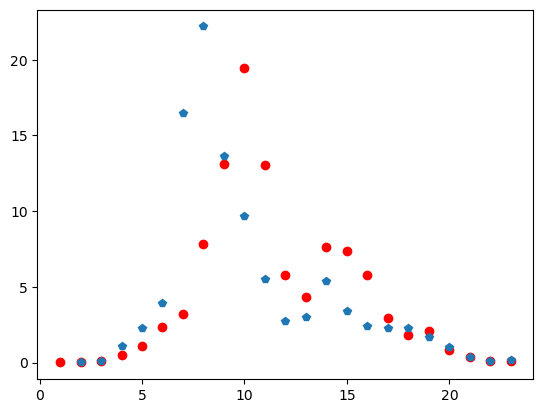

In [16]:
plt.plot(count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "H_ARR", "POND_JOUR",24)["H_ARR"],count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "H_ARR", "POND_JOUR",24)["Proportion"],'ro')
plt.plot(count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "H_ARR", "POND_JOUR",24)["H_ARR"],count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "H_ARR", "POND_JOUR",24)["Proportion"],'p')
plt.show()

In [17]:
results=[] #tableau des occurences pondérées heure par heure pour un graphique
for h in range(0,24) :
    data = count_occ_pond(EMP_prems[EMP_prems["H_ARR"]==h], "Lieu_Arrivee", "POND_JOUR", 10)
    data["Heure"]=float(h)
    results.append(data)

results=pd.concat(results, ignore_index=True)


In [18]:
#On crée une fonction retirant les heures n'ayant pas assez d'occurences (étant donné qu'on affiche dans le graphique des proportions)
def limiter(df, nom_var, precision=1000):
    
    limiter=df[nom_var].sum()/precision #si une heure a moins de limiter occurences pond, alors on l'omet
    
    H_occ_pond=pd.DataFrame(df.groupby("Heure")[nom_var].sum())
    H_occ_pond = H_occ_pond.rename(columns={nom_var: "Occ_H"}) #on rajoute Occ_H, le nombre d'occurences pond par h
   
    results = pd.merge(df, H_occ_pond, on='Heure', how='left')
    results = results[results["Occ_H"] >= limiter]
    return results

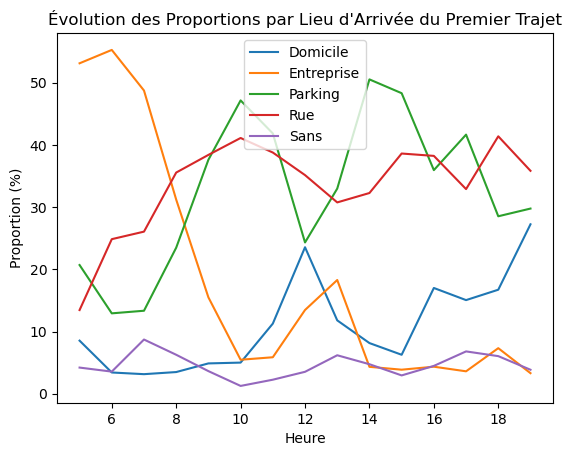

In [19]:
results=limiter(results, "Occurences pondérées",100)

fig, ax = plt.subplots()
for key, group in results.groupby("Lieu_Arrivee"):
    ax.plot(group["Heure"], group["Proportion"], label=key)

ax.set_xlabel("Heure")
ax.set_ylabel("Proportion (%)")
ax.set_title("Évolution des Proportions par Lieu d'Arrivée du Premier Trajet")
ax.legend()
plt.show()

# Lieu de la dernière arrivée

In [20]:
EMP_last = pd.merge(EMP, EMP.groupby("IDENT_IND")["num_dep_V"].max().reset_index(), on='IDENT_IND', how='left')
EMP_last = EMP_last[EMP_last["num_dep_V_x"]==EMP_last["num_dep_V_y"]]
EMP_last.head()

,IDENT_IND,IDENT_MEN,MVEH,POND_JOUR,MOTPREC,MMOTIFDES,MSTATION,Motif,Stationnement,Lieu_Depart,...,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,KVAQUIV,TRAVAILLE,Segment_detail,IDENT_V,Segment,num_dep_V_x,num_dep_V_y
1,110000011400001,1100000114000,1,"9891,108772",2.1,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,...,2029-01-03 14:45:00,2029-01-03 14:50:00,"2,2",1.0,2,Particulier,110000011400001_1_Particulier,Particulier,2,2
3,110000011500001,1100000115000,2,"5275,2959481",1.4,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,...,2029-01-05 10:30:00,2029-01-05 11:00:00,28,1.0,2,Particulier,110000011500001_2_Particulier,Particulier,2,2
5,110000013500002,1100000135000,1,"24058,724023",9.1,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Entreprise,...,2029-01-03 23:45:00,2029-01-03 23:55:00,"5,3214103219",1.0,1,Particulier,110000013500002_1_Particulier,Particulier,2,2
7,110000013600001,1100000136000,1,"20658,322154",9.1,1.1,1,Retour au domicile,"Stationnement sur la voie publique, gratuit sa...",Rue,...,2029-01-02 18:00:00,2029-01-02 19:00:00,"25,232498723",1.0,1,Particulier,110000013600001_1_Particulier,Particulier,2,2
9,110000014400001,1100000144000,2,"31828,347792",2.1,1.1,1,Retour au domicile,"Stationnement sur la voie publique, gratuit sa...",Rue,...,2029-01-06 09:15:00,2029-01-06 09:25:00,3,1.0,1,Particulier,110000014400001_2_Particulier,Particulier,2,2


In [21]:
#création d'une variable weekend (si les diffs entre samedi et dimanche sont faibles)
EMP_last.loc[:, "WE"] = 0
EMP_last.loc[EMP_last["TYPE_jour"].isin(["samedi", "dimanche"]), "WE"] = 1

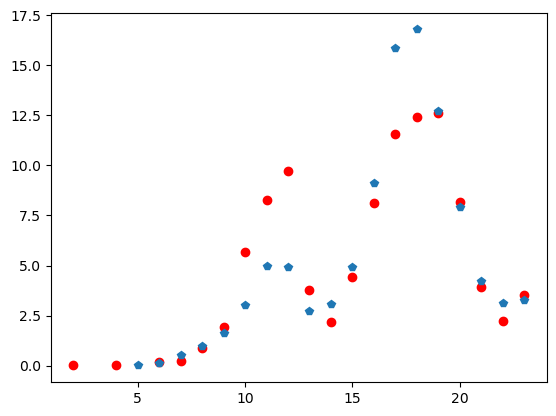

In [22]:
for h in range(0,24):
    EMP_last.loc[(EMP_last["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) >= h) & (EMP_last["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) <= h+1), "H_ARR"]=int(h)

plt.plot(count_occ_pond(EMP_last[EMP_last["WE"]==1], "H_ARR", "POND_JOUR",24)["H_ARR"],count_occ_pond(EMP_last[EMP_last["WE"]==1], "H_ARR", "POND_JOUR",24)["Proportion"],'ro')
plt.plot(count_occ_pond(EMP_last[EMP_last["WE"]==0], "H_ARR", "POND_JOUR",24)["H_ARR"],count_occ_pond(EMP_last[EMP_last["WE"]==0], "H_ARR", "POND_JOUR",24)["Proportion"],'p')
plt.show()

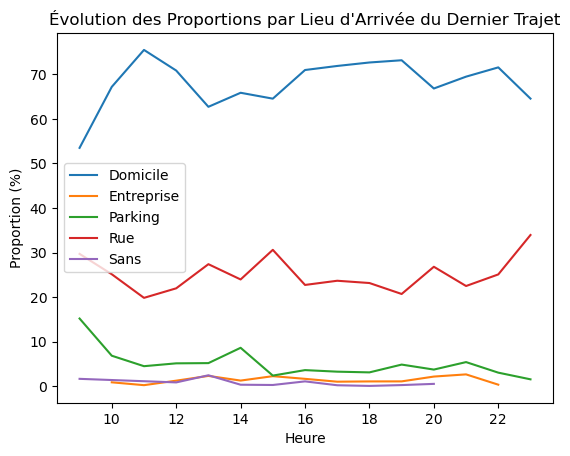

In [23]:
results=[] #tableau des occurences pondérées heure par heure pour un graphique
for h in range(0,24) :
    data = count_occ_pond(EMP_last[EMP_last["H_ARR"]==h], "Lieu_Arrivee", "POND_JOUR", 10)
    data["Heure"]=float(h)
    results.append(data)

results=pd.concat(results, ignore_index=True)

results=limiter(results, "Occurences pondérées",100) #on ôte les heures ayant peu de données

fig, ax = plt.subplots()
for key, group in results.groupby("Lieu_Arrivee"):
    ax.plot(group["Heure"], group["Proportion"], label=key)

ax.set_xlabel("Heure")
ax.set_ylabel("Proportion (%)")
ax.set_title("Évolution des Proportions par Lieu d'Arrivée du Dernier Trajet")
ax.legend()
plt.show()

# Les proportions sont-elles statistiquement constantes dans le temps (pour le dernier trajet)?

On commence par effectuer une régression simple de la proportion d'individus se garant pour leur dernier trajet à leur domicile. On utilise le tableau produit ci-dessus.

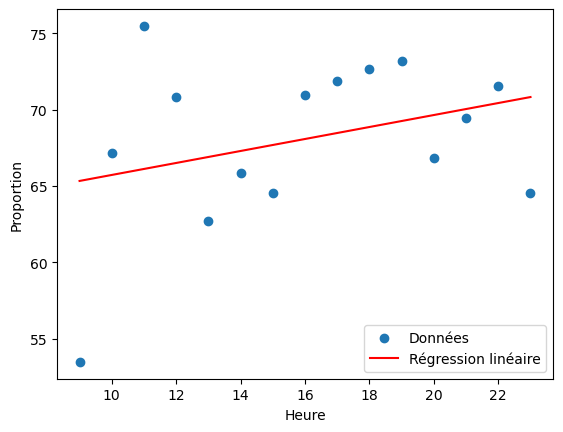

Coefficient de pente (slope): 0.39217857142857127
Terme constant (intercept): 61.80514285714284
Valeur de r (corrélation): 0.3201805224588897
Valeur de p (p-value): 0.24465717734354428


In [24]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

results=results[results["Lieu_Arrivee"]=="Domicile"]

# Extraction des colonnes pertinentes
heure = results["Heure"]
proportion = results["Proportion"]

# Calcul de la régression linéaire
slope, intercept, r_value, p_value, std_err = linregress(heure, proportion)

# Affichage de la régression linéaire
plt.scatter(heure, proportion, label='Données')
plt.plot(heure, intercept + slope * heure, 'r', label='Régression linéaire')
plt.xlabel('Heure')
plt.ylabel('Proportion')
plt.legend()
plt.show()

# Affichage des coefficients de la régression
print(f"Coefficient de pente (slope): {slope}")
print(f"Terme constant (intercept): {intercept}")
print(f"Valeur de r (corrélation): {r_value}")
print(f"Valeur de p (p-value): {p_value}")


La régression est grossière et ne montre rien car on n'a que 24 entrées. On va donc revenir à la base de données brutes (ne prenant en compte que les derniers trajets).
On effectue un test du chi² d'indépendance, l'objectif étant de vérifier que la proportion de personnes pour chaque lieu d'arrivée est indépendante du temps. (à vérifier)

In [25]:
from scipy.stats import chi2_contingency

# Créer une table de contingence pour le test du chi-carré
contingency_table = pd.crosstab(EMP_last['Lieu_Arrivee'], EMP_last['H_ARR'])

# Effectuer le test du chi-carré
chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

# Afficher les résultats du test du chi-carré
print("Statistique du Chi-carré :", chi2_stat)
print("P-value :", p_val)

# Interprétation des résultats
if p_val < 0.05:
    print("Il y a des variations significatives des fréquences d'arrivées entre les lieux d'arrivée.")
else:
    print("Les fréquences d'arrivées entre les lieux d'arrivée sont constantes dans le temps.")


Statistique du Chi-carré : 359.04324434785843
P-value : 5.511256516129063e-37
Il y a des variations significatives des fréquences d'arrivées entre les lieux d'arrivée.


# Probabilité du premier lieu de départ

In [26]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "Lieu_Depart", "POND_JOUR") #lieu du premier départ en semaine

,Lieu_Depart,Occurences pondérées,Proportion
0,Domicile,9.446434e+07,70.45
1,Rue,3.227537e+07,24.07
2,Parking,4.728547e+06,3.53
3,Entreprise,2.117524e+06,1.58
4,Sans,5.106281e+05,0.38


In [27]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "Lieu_Depart", "POND_JOUR")  #lieu du premier départ en WE

,Lieu_Depart,Occurences pondérées,Proportion
0,Domicile,3.120083e+07,70.62
1,Rue,1.028734e+07,23.28
2,Parking,2.230952e+06,5.05
3,Entreprise,3.357412e+05,0.76
4,Sans,1.290180e+05,0.29


On ne remarque pas de différences significatives entre la semaine et le WE (surtout pour domicile et rue représentant plus de 93% de l'échantillon). On ne fera donc pas de distinction entre les deux.

In [28]:
count_occ_pond(EMP_prems, "Lieu_Depart", "POND_JOUR") 

,Lieu_Depart,Occurences pondérées,Proportion
0,Domicile,1.256652e+08,70.49
1,Rue,4.256271e+07,23.87
2,Parking,6.959499e+06,3.90
3,Entreprise,2.453265e+06,1.38
4,Sans,6.396461e+05,0.36


On fait l'hypothèse que le lieu de départ n'est pas correlé à l'heure du départ (cela pourrait être le cas pour les individus partant de leur travail, ayant donc travaillé de nuit, mais ce cas est minime). Les autres individus partent du lieu de stationnement de leur foyer.

In [29]:
#On définit une fonction qui selon les probabilités ci-dessus, va produire le lieu de départ de n individus
def loi_lieu_depart(n=1, p_domicile=70.49/100, p_rue=23.87/100, p_parking=3.90/100, p_entreprise=1.38/100, p_sans=0.36/100):
    matrice_initiale = [random.uniform(0, 1) for k in range(n)]
    for i in range(n):
        if matrice_initiale[i] <= p_domicile:
            matrice_initiale[i] = "Domicile"
        elif matrice_initiale[i] <= p_domicile + p_rue:
            matrice_initiale[i] = "Rue"
        elif matrice_initiale[i] <= p_domicile + p_rue + p_parking:
            matrice_initiale[i] = "Parking"
        elif matrice_initiale[i] <= p_domicile + p_rue + p_parking + p_entreprise:
            matrice_initiale[i] = "Entreprise"
        else:
            matrice_initiale[i] = "Sans"
    
    return matrice_initiale

In [30]:
#Test de la fonction
pd.DataFrame(loi_lieu_depart(10000)).value_counts()/10000

0         
Domicile      0.7045
Rue           0.2434
Parking       0.0363
Entreprise    0.0123
Sans          0.0035
Name: count, dtype: float64

# Matrice de transition par tranche 

In [31]:
#Création de la variable Plage horraire (00-11h,00-11h,14h-17h,17h-00h)

In [32]:
EMP["HEURE_ARRIVEE"]=EMP["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float)

In [33]:
EMP.loc[EMP["HEURE_ARRIVEE"].between(0, 11),"Plage_horraire"] = "00-11h"
EMP.loc[EMP["HEURE_ARRIVEE"].between(11, 14),"Plage_horraire"] = "11-14h"
EMP.loc[EMP["HEURE_ARRIVEE"].between(14, 17),"Plage_horraire"] = "14-17h"
EMP.loc[EMP["HEURE_ARRIVEE"].between(17, 24),"Plage_horraire"] = "17-00h"

In [34]:
EMP["Plage_horraire"].value_counts()

Plage_horraire
17-00h    6693
00-11h    6529
11-14h    4794
14-17h    4510
Name: count, dtype: int64

Problème : un individu réalise plus de deux trajets en une plage horraire. Pour réaliser la matrice de transition, doit-on ne prendre en compte que le trajet où il reste le plus longtemps garé ?

In [35]:
EMP.groupby(["IDENT_IND", "Plage_horraire"]).size().reset_index(name='Nombre_occurrences').value_counts('Nombre_occurrences')

Nombre_occurrences
1    9193
2    4279
3    1010
4     303
5      81
6      14
7       4
8       2
Name: count, dtype: int64

On remarque que ce cas n'est pas annecdotique dans notre base de données.
Dans ces cas, où un individu effectue plus de deux déplacements dans une même plage horraire, on va garder le lieu d'arrivé le plus long. On aura donc un voyage par plage.
Bien sûr, on complexifiera la modélisation par la suite.

In [36]:
# Compter le nombre d'occurrences pour chaque combinaison de "IDENT_IND" et "Plage_horraire"
occurrences_par_plage = EMP.groupby(["IDENT_IND", "Plage_horraire"]).size().reset_index(name='Nombre_occurrences_plage')

#Fusionner avec le DataFrame original pour obtenir les lignes correspondantes
EMP = pd.merge(EMP, occurrences_par_plage, on=["IDENT_IND", "Plage_horraire"])

In [37]:
#On garde seulement les couples ind, plage n'ayant qu'une occurence et
EMP_plage = EMP[EMP['Nombre_occurrences_plage'] == 1][["IDENT_IND","Plage_horraire","Lieu_Depart","Lieu_Arrivee"]]
EMP_plage.head(10)

,IDENT_IND,Plage_horraire,Lieu_Depart,Lieu_Arrivee
2,110000011500001,00-11h,Domicile,Parking
3,110000011500001,11-14h,Parking,Domicile
4,110000013500002,14-17h,Domicile,Entreprise
5,110000013500002,17-00h,Entreprise,Domicile
6,110000013600001,00-11h,Rue,Rue
7,110000013600001,17-00h,Rue,Rue
10,110000014600002,00-11h,Domicile,Entreprise
13,110000016500001,00-11h,Domicile,Parking
14,110000016500001,14-17h,Parking,Domicile
16,110000022500001,17-00h,Parking,Rue


Pour des raisons de faisabilité, je vais plutôt transformer plusieurs voyages dans la même plage horaire en un seul. Exemple : Domicile ->Rue->Entreprise deviendra Domicile -> Entreprise.
On aura des voyages sur place (Domicile -> Domicile par exemple), néanmoins ils ne sont pas dérangeants, étant donné qu'on construit une matrice de transition, et il y en a déjà.

In [38]:
EMP_temp=EMP[EMP['Nombre_occurrences_plage'] > 1]

# Grouper par "IDENT_IND" et "Plage_horraire" et appliquer une fonction qui le premier Lieu_Depart et le dernier Lieu_Arrivee
EMP_temp = EMP_temp.groupby(["IDENT_IND", "Plage_horraire"]).apply(lambda x: x.sort_values(by="HEURE_ARRIVEE")).reset_index(drop=True)
EMP_temp = EMP_temp.groupby(["IDENT_IND", "Plage_horraire"]).agg({'Lieu_Depart': 'first', 'Lieu_Arrivee': 'last'}).reset_index()

EMP_temp= EMP_temp[["IDENT_IND","Plage_horraire","Lieu_Depart","Lieu_Arrivee"]]

/tmp/ipykernel_72789/662960807.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  EMP_temp = EMP_temp.groupby(["IDENT_IND", "Plage_horraire"]).apply(lambda x: x.sort_values(by="HEURE_ARRIVEE")).reset_index(drop=True)


In [39]:
EMP_temp.head(10)

,IDENT_IND,Plage_horraire,Lieu_Depart,Lieu_Arrivee
0,110000011400001,14-17h,Domicile,Domicile
1,110000014400001,00-11h,Rue,Rue
2,110000014600002,17-00h,Entreprise,Domicile
3,110000022500001,14-17h,Entreprise,Parking
4,110000022600002,00-11h,Domicile,Domicile
5,110000026400001,00-11h,Domicile,Domicile
6,110000026400001,14-17h,Domicile,Parking
7,110000026400001,17-00h,Parking,Domicile
8,110000031400001,00-11h,Domicile,Rue
9,110000031500001,00-11h,Domicile,Entreprise


In [40]:
#On concatène les deux bases créées
EMP_plage2 = pd.concat([EMP_plage, EMP_temp], ignore_index=True).sort_values(by="IDENT_IND").reset_index(drop=True)

#Test validé :
EMP_plage2.groupby(["IDENT_IND", "Plage_horraire"]).size().reset_index(name='Nombre_occurrences').value_counts('Nombre_occurrences')

Nombre_occurrences
1    14886
Name: count, dtype: int64

Pour créer une matrice de transition convenable, on doit comptabiliser aussi les non-déplacements.Donc, par individu, s'il n'effectue pas de trajet dans une plage, on crée un trajet allant de là où il était à là où il était ou de là où il sera à là où il sera (Exemple: 00-11h Domicile-Entreprise / 11h-14h : rien -> 11h14H : Entreprise-Entreprise).

In [41]:
# Utilisation de pivot_table pour passer au format wide
EMP_wide = EMP_plage2.pivot_table(index='IDENT_IND', columns='Plage_horraire', values=['Lieu_Depart', 'Lieu_Arrivee'], aggfunc='first')
EMP_wide.columns = [f'{col[0]}_{col[1]}' for col in EMP_wide.columns]

#EMP_wide = EMP_wide.reset_index()#On doit remplacer toutes les valeurs manquantes
EMP_wide

,Lieu_Arrivee_00-11h,Lieu_Arrivee_11-14h,Lieu_Arrivee_14-17h,Lieu_Arrivee_17-00h,Lieu_Depart_00-11h,Lieu_Depart_11-14h,Lieu_Depart_14-17h,Lieu_Depart_17-00h
IDENT_IND,,,,,,,,
110000011400001,NaN,NaN,Domicile,NaN,NaN,NaN,Domicile,NaN
110000011500001,Parking,Domicile,NaN,NaN,Domicile,Parking,NaN,NaN
110000013500002,NaN,NaN,Entreprise,Domicile,NaN,NaN,Domicile,Entreprise
110000013600001,Rue,NaN,NaN,Rue,Rue,NaN,NaN,Rue
110000014400001,Rue,NaN,NaN,NaN,Rue,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
940000036100001,NaN,NaN,Domicile,Domicile,NaN,NaN,Domicile,Domicile
940000036400001,Entreprise,NaN,NaN,Rue,Rue,NaN,NaN,Entreprise
940000041500002,Parking,Domicile,Domicile,NaN,Domicile,Parking,Domicile,NaN


Pour chaque ind, on crée deux variables : la première et dernière plage de voyage.
Puis on remplace les NaN, avec le premier lieu de départ si on est dans une plage avant, et avec le dernier lieu de départ sinon.

In [42]:
#On crée deux variables : la première et dernière plage de voyage.
EMP_wide["rang_prem"]=0
EMP_wide["rang_der"]=0

EMP_wide["rang_prem"]=EMP_wide[["Lieu_Depart_00-11h",	"Lieu_Depart_11-14h",	"Lieu_Depart_11-14h",	"Lieu_Depart_17-00h"]].notna().idxmax(axis=1) #premier départ
EMP_wide["rang_der"] = EMP_wide[["Lieu_Arrivee_00-11h", "Lieu_Arrivee_11-14h", "Lieu_Arrivee_14-17h", "Lieu_Arrivee_17-00h"]].iloc[:, ::-1].notna().idxmax(axis=1) 

In [43]:
#On recode les variables catégorielles pour indiquer le numéro de la colonne
#dict_prem = {"Lieu_Depart_00-11h": 1, "Lieu_Depart_11-14h": 2, "Lieu_Depart_14-17h": 3, "Lieu_Depart_17-00h" : 4}
#dict_der = {"Lieu_Arrivee_00-11h": 5, "Lieu_Arrivee_11-14h": 6, "Lieu_Arrivee_14-17h": 7, "Lieu_Arrivee_17-00h" : 8}
#EMP_wide['rang_prem'] = EMP_wide['rang_prem'].replace(dict_prem)
#EMP_wide['rang_der'] = EMP_wide['rang_der'].replace(dict_der)

On abandonne cette approche

# Modélisation lieu d'arrivée par rapport à la plage horraire et le lieu de départ

Pour chaque lieu de stationnement et chaque plage horraire, on va calculer les probailités du prochain lieu de stationnement

In [72]:
#On va créer un e fonction liée à count_occ_pound qui pour chaque plage horraire va nous envoyer la proba de Lieu_Arrivee pour chaque Lieu_Depart

def transition_plage(plage):
    Lieux = ["Domicile","Rue","Entreprise","Parking","Sans"] 
    results=None
    for Lieu in Lieux:
        data = EMP[(EMP["Plage_horraire"] == plage) & (EMP["Lieu_Depart"] == Lieu)]
        results_temp = count_occ_pond(data, 'Lieu_Arrivee', 'POND_JOUR').iloc[:, [0, 2]]

        results_temp["Proportion"] = results_temp["Proportion"] / 100
        results_temp.rename(columns={'Proportion': 'Proba'+'_'+Lieu}, inplace=True)


        if results is None: #on fusionne toutes les proportions pour créer la matrice
            results = results_temp
        else:
            results = pd.merge(results, results_temp, on='Lieu_Arrivee')

    return results


# Appel de la fonction avec la plage "00-11h"
transition_plage("00-11h")

,Lieu_Arrivee,Proba_Domicile,Proba_Rue,Proba_Entreprise,Proba_Parking,Proba_Sans
0,Rue,0.3177,0.3900,0.2824,0.2187,0.1869
1,Entreprise,0.2906,0.1977,0.2901,0.0968,0.1710
2,Parking,0.2842,0.2365,0.0907,0.2697,0.2154
3,Sans,0.0588,0.0261,0.0163,0.0207,0.0465
4,Domicile,0.0487,0.1498,0.3206,0.3941,0.3803


In [139]:
#Maintenant on va créer une fonction à laquelle on donne un lieu de départ et une heure de départ et qui nous donne un lieu d'arrivée
#En suivant les proba obtenues ci-dessus

def lieu_arrivee(lieu_depart, heure_depart): #juste l'heure, les minutes ne sont pas utiles
    if heure_depart<11: #on trouve la plage horraire correspondante
        plage="00-11h"
    elif heure_depart<14 :
        plage="11-14h"
    elif heure_depart<17 :
        plage="14-17h"
    else:
        plage="17-00h"

    table=transition_plage(plage)[["Lieu_Arrivee", "Proba_"+lieu_depart]] #on prend les proba de déplacement pour cette plage et ce lieu de départ
    
    proba_parking = table.loc[table["Lieu_Arrivee"] == "Parking"].iloc[0,1]#proba d'aller dans un parking selon l'heure et le lieu de départ donnés.
    proba_domicile = table.loc[table["Lieu_Arrivee"] == "Domicile"].iloc[0,1]
    proba_rue = table.loc[table["Lieu_Arrivee"] == "Rue"].iloc[0,1]
    proba_entreprise = table.loc[table["Lieu_Arrivee"] == "Entreprise"].iloc[0,1]
    proba_sans = table.loc[table["Lieu_Arrivee"] == "Sans"].iloc[0,1]
    
    tirage=random.uniform(0, 1) #on construit la loi avec les probas obtenues
    if tirage < proba_parking:
        Lieu_Arrivee="Parking"
    elif tirage < proba_parking + proba_domicile:
        Lieu_Arrivee="Domicile"
    elif tirage < proba_parking + proba_domicile + proba_rue:
        Lieu_Arrivee="Rue"
    elif tirage < proba_parking + proba_domicile + proba_rue + proba_entreprise:
        Lieu_Arrivee="Entreprise"
    else:
        Lieu_Arrivee="Sans"
    
    return Lieu_Arrivee

lieu_arrivee("Domicile", 13.30)

'Rue'

In [140]:
EMP

,IDENT_IND,IDENT_MEN,MVEH,POND_JOUR,MOTPREC,MMOTIFDES,MSTATION,Motif,Stationnement,Lieu_Depart,...,INSTANT_ARRIVEE,DISTANCE,KVAQUIV,TRAVAILLE,Segment_detail,IDENT_V,Segment,num_dep_V,Plage_horraire,Nombre_occurrences_plage
0,110000011400001,1100000114000,1,"9891,108772",1.1,2.1,5,Se rendre dans une grande surface ou un centre...,Emplacement dans un parking public ou commerci...,Domicile,...,2029-01-03 14:20:00,"2,2",1.0,2,Particulier,110000011400001_1_Particulier,Particulier,1,14-17h,2
1,110000011400001,1100000114000,1,"9891,108772",2.1,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,...,2029-01-03 14:50:00,"2,2",1.0,2,Particulier,110000011400001_1_Particulier,Particulier,2,14-17h,2
2,110000011500001,1100000115000,2,"5275,2959481",1.1,1.4,6,"Étudier (école, lycée, université)",Emplacement dans un parking public ou commerci...,Domicile,...,2029-01-05 08:45:00,28,1.0,2,Particulier,110000011500001_2_Particulier,Particulier,1,00-11h,1
3,110000011500001,1100000115000,2,"5275,2959481",1.4,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,...,2029-01-05 11:00:00,28,1.0,2,Particulier,110000011500001_2_Particulier,Particulier,2,11-14h,1
4,110000013500002,1100000135000,1,"24058,724023",1.1,9.1,4,Travailler dans son lieu fixe et habituel,"Emplacement privé, gratuit (y compris domicile)",Domicile,...,2029-01-03 15:15:00,"5,3214103219",1.0,1,Particulier,110000013500002_1_Particulier,Particulier,1,14-17h,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22521,940000044100001,9400000441000,1,"15761,857518",3.1,2.1,5,Se rendre dans une grande surface ou un centre...,Emplacement dans un parking public ou commerci...,Rue,...,2029-01-03 10:35:00,1,1.0,2,Particulier,940000044100001_1_Particulier,Particulier,2,00-11h,2
22522,940000044100001,9400000441000,1,"15761,857518",2.1,4.1,3,"Démarche administrative, recherche d'informations","Stationnement sur la voie publique, payant",Parking,...,2029-01-03 11:35:00,1,1.0,2,Particulier,940000044100001_1_Particulier,Particulier,3,11-14h,2
22523,940000044100001,9400000441000,1,"15761,857518",4.1,1.1,1,Retour au domicile,"Stationnement sur la voie publique, gratuit sa...",Rue,...,2029-01-03 13:00:00,"36,476190476",1.0,2,Particulier,940000044100001_1_Particulier,Particulier,4,11-14h,2
22524,940000052100001,9400000521000,2,"14068,334434",1.1,9.1,4,Travailler dans son lieu fixe et habituel,"Emplacement privé, gratuit (y compris domicile)",Rue,...,2029-01-03 06:45:00,"21,661727133",1.0,1,Particulier,940000052100001_2_Particulier,Particulier,1,00-11h,1
